Libraries used for this model:
- keras
- numpy
- matplotlib
- tensorflow
- sklearn

Now we import the necessary packages

In [114]:
import numpy as np
from matplotlib import pyplot
from keras.initializers import HeNormal
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split

Now we read our processed datasets, explanations on how to create the dataset can be found in the Readme.

1. We are gonna use the datasets from LAN server (12458 unique ranked matches) to train our algorithm
2. We are gonna divide the training dataset into training and validation. Having the validation 20% of the training dataset.
3. Lastly we are gonna use the datasets from NA server (4552 unique ranked matches) to test our algorithm.

Notice that the CSV file contains on each line the 44 features of the match and at the end 1 if the blue team (First team on the sample) won or 0 otherwise.

In [115]:
lan_dataset = np.loadtxt('/Users/renegonzalez/Desktop/DNN LoL/lan_dataset.csv', delimiter=',', dtype=np.float32)
na_dataset = np.loadtxt('/Users/renegonzalez/Desktop/DNN LoL/na_dataset.csv', delimiter=',', dtype=np.float32)

np.random.shuffle(lan_dataset)

x_train = lan_dataset[:, 0:44]
y_train = lan_dataset[:, 44]

x_test = na_dataset[:, 0:44]
y_test = na_dataset[:, 44]


x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

print(f'x_train size: {len(x_train)}')
print(f'y_train size: {len(y_train)}')

print(f'x_val size: {len(x_val)}')
print(f'y_val size: {len(y_val)}')

print(f'x_test size: {len(x_test)}')
print(f'y_test size: {len(y_test)}')


x_train size: 9966
y_train size: 9966
x_val size: 2492
y_val size: 2492
x_test size: 4552
y_test size: 4552


Now we create the model architecture using keras and following the structure described in the paper:

• Alternating dropout, normalization, and dense layers for a total of 15 layers (5 dropout, 5 normalization, and 5 dense
layers). Each group of alternating layers had 160, 128, 64, 32, and 16 neurons, in that order.

- Each dropout layer had a dropout rate of 0.69%.
- Each normalization layer utilized batch normalization.
- Each dense layer used Exponential Linear Unit (ELU) activation, He initialization.
- A 1 × 1 dense layer with Sigmoid activation

Finally we compile using basic parameters for classification problems

In [116]:
# Create the model architecture lol
initializer = HeNormal()
model = Sequential([
    Dropout(0.69, input_dim=44),
    BatchNormalization(),
    Dense(160, activation='elu', kernel_initializer=initializer),

    Dropout(0.69),
    BatchNormalization(),
    Dense(128, activation='elu', kernel_initializer=initializer),

    Dropout(0.69),
    BatchNormalization(),
    Dense(64, activation='elu', kernel_initializer=initializer),

    Dropout(0.69),
    BatchNormalization(),
    Dense(32, activation='elu', kernel_initializer=initializer),

    Dropout(0.69),
    BatchNormalization(),
    Dense(16, activation='elu', kernel_initializer=initializer),

    Dense(1, activation='sigmoid'),
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Now we train the model with our train dataset and our validation dataset.

**Note:**
After multiple tests I found that 50 epochs and a batch_size of 200 are the best parameters, feel free to try change them in your code.

In [117]:
# fit the model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=200)

Epoch 1/50
50/50 [==============================] - 7s 27ms/step - loss: 0.7592 - accuracy: 0.5088 - val_loss: 0.6533 - val_accuracy: 0.6882
Epoch 2/50
50/50 [==============================] - 1s 17ms/step - loss: 0.7204 - accuracy: 0.5040 - val_loss: 0.6657 - val_accuracy: 0.6212
Epoch 3/50
50/50 [==============================] - 1s 14ms/step - loss: 0.7032 - accuracy: 0.5124 - val_loss: 0.6711 - val_accuracy: 0.6152
Epoch 4/50
50/50 [==============================] - 1s 14ms/step - loss: 0.6984 - accuracy: 0.5235 - val_loss: 0.6668 - val_accuracy: 0.6726
Epoch 5/50
50/50 [==============================] - 1s 11ms/step - loss: 0.6933 - accuracy: 0.5347 - val_loss: 0.6592 - val_accuracy: 0.7343
Epoch 6/50
50/50 [==============================] - 1s 14ms/step - loss: 0.6923 - accuracy: 0.5374 - val_loss: 0.6435 - val_accuracy: 0.7705
Epoch 7/50
50/50 [==============================] - 1s 13ms/step - loss: 0.6878 - accuracy: 0.5421 - val_loss: 0.6174 - val_accuracy: 0.8090
Epoch 8/50
50

Now we plot the history of loss using matplotlib

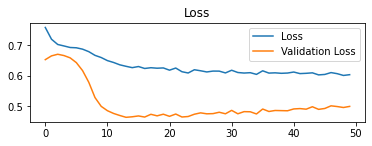

In [118]:
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='Loss')
pyplot.plot(history.history['val_loss'], label='Validation Loss')
pyplot.legend()
pyplot.show()


Now we plot the history of accuracy using matplotlib

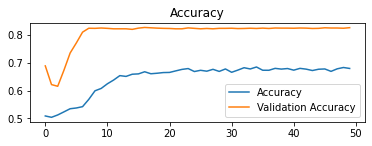

In [119]:
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='Accuracy')
pyplot.plot(history.history['val_accuracy'], label='Validation Accuracy')
pyplot.legend()
pyplot.show()


And finally we evaluate our model using the training dataset, validation dataset and testing dataset.

In [120]:
# evaluate the model
_, train_acc = model.evaluate(x_train, y_train, verbose=0)
_, val_acc = model.evaluate(x_val, y_val, verbose=0)
_, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Train: %.3f, Validation: %.3f, Tests: %.3f' % (train_acc, val_acc, test_acc))

Train: 0.835, Validation: 0.825, Tests: 0.825


### Results

Even though we trained our model with matches from LAN server we can see that it performed really well using the matches from a different server. Having an insanely high 82.5% accuracy.